# Southeastern Woody Wetland Analysis
#### NOTE: Many but not all "save" statements have been commented out.

# Required data
To run this analysis, you need access to GAP habitat maps (https://www.sciencebase.gov/catalog/item/527d0a83e4b0850ea0518326), the GAP WHR Database, the GAP Species Database, the GAP analytic database, 2001 GAP Land Cover (https://www.sciencebase.gov/catalog/item/5540e2d7e4b0a658d79395db), and rasterized PAD-US data.

# Import packages
The following packages are required for this analysis:  arcpy 10.2.1;  GAPAnalysis >=0.3 available at https://github.com/nmtarr/GAPAnalysis; GAPProduction >=1.3 available at https://github.com/nmtarr/GAPProduction; pandas >= 0.20.1;  matplotlib == 2.1.0;  numpy >=1.13.3

In [10]:
import sys
import pandas as pd
import gapproduction as gp
import pickle
import gapanalysis as ga
import arcpy
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Important variables
Name of the project directories where input data and results belong.

In [11]:
workDir = "T:/Floodplain_Forests_2016/"
dataDir = workDir + "Data/"
tempDir = workDir + "Temp/"
intermDir = workDir + "Intermediate/"
resultDir = workDir + "Results/"

Locations of input data layers

In [12]:
# Directory where GAP habitat maps are saved
habMapDir = "P:/Proj3/USGap/Vert/Model/Output/CONUS/Null123/"
# Directory with seasonal, binary (0 and 1) copies of GAP habitat maps
seasonalhabMapDir = "P:/Proj3/USGap/Vert/Model/Output/CONUS/01/"
# Location of land cover maps
lcMapDir = "P:/Proj3/USGap/Vert/Model/data/LandCover"
lcMap = "P:/Proj3/USGap/Analysis/Data/lcv1vertmosai"
# Path to CONUS extent 30m raster of zeros except for 9 cells in top, left coded as "1".
conus_extent = "P:/Proj3/USGap/Vert/Model/data/conus_ext_cnt"
# Path to a snap grid to use in geoprocessing
snap_raster = "P:/Proj3/USGap/Vert/Model/data/snapgrid"
# Path to rasterized version of protection status from PAD-US 1.4
PADUS_Status = "P:/Proj3/USGap/Analysis/Data/PAD14s2001.tif"
# Path to boundary of the study area (SE and Gulf Coastal Plains)
AOI = dataDir + "StudyRegion.shp"
# Additional text in the habitat map file names aside from the gap species code.
habmapSuffix = "_CONUS_HabMap_2001v1.tif"
# Path to a copy of the SHUCS
hucs = 'P:/Proj3/USGAP/Vert/Model/data/HucRng/Hucs.shp'
# Path to csv file where percent overlap should get recorded.
overlayTable = resultDir + "Percent_FloodplainForest/Percent_in_Floodplain_Master.csv"
# Paths to species richness tifs with national extent.  One for summer, one for winter.
summerRichness = resultDir + "Top_Summer/Top_Summer_Richness.tif"
winterRichness = resultDir + "Top_Winter/Top_Winter_Richness.tif"

Variables related to land cover processing.

In [13]:
# List of floodplain forest map units.
floodplainSystemCSV = dataDir + "/Ecological systems of interest.csv"

# Placeholder code to use for nulls in floodplain binary map.
placeholder_code = 99

# Name of binary floodplain layer (without NoDatas)
floodplainBinary = resultDir + "Floodplains10&{0}.tif".format(placeholder_code)

# Name of floodplain layer (with NoDatas)
floodplain = resultDir + "Floodplain.tif"

Define some species lists and set some names for files that will be created later.

In [14]:
# Species list derived by querying range database for native species in ecoregions
# that could have floodplain forests. 
import pickle
studyRegionList = pickle.load(open(resultDir + "studyRegionList.pkl"))

# studyRegionList converted to null123 raster names.
null123List = [i[0] + i[1:5].upper() + i[5:] + habmapSuffix for i in studyRegionList]

# Location of lists of species exceeding the % habitat overlay threshold
winterTopSpList = resultDir + "TopWinterSpecies.csv"
summerTopSpList = resultDir + "TopSummerSpecies.csv"
TopSpList = resultDir + "TopSpecies.csv"

Names to use for various richness rasters that are created and used during the analysis.

In [15]:
# Paths to richness rasters
richnessPathsCONUS = {
"amphibian": dataDir + "Amphibian_Richness.tif",
"bird_summer": dataDir + "Bird_Summer_Richness.tif",
"bird_winter": dataDir + "Bird_Winter_Richness.tif",
"reptile": dataDir + "Reptile_Richness.tif",
"mammal": dataDir + "Mammal_Richness.tif",
"all_taxa": dataDir + "All_Richness.tif"}

richnessPathsSE = {
"amphibian": resultDir + "Amphibian_Richness_SE.tif",
"bird_summer": resultDir + "Bird_Summer_Richness_SE.tif",
"bird_winter": resultDir + "Bird_Winter_Richness_SE.tif",
"reptile": resultDir + "Reptile_Richness_SE.tif",
"mammal": resultDir + "Mammal_Richness_SE.tif",
"all_taxa": resultDir + "All_Richness_SE.tif"}    

richnessPathsFlood = {
"amphibian": resultDir + "Amphibian_Richness_Flood.tif",
"bird_summer": resultDir + "Bird_Summer_Richness_Flood.tif",
"bird_winter": resultDir + "Bird_Winter_Richness_Flood.tif",
"reptile": resultDir + "Reptile_Richness_Flood.tif",
"mammal": resultDir + "Mammal_Richness_Flood.tif",
"all_taxa": resultDir + "All_Richness_Flood.tif"}    

## Set geoprocessing environment variables

In [16]:
arcpy.ResetEnvironments()
arcpy.CheckOutExtension("Spatial")
arcpy.env.snapRaster=snap_raster
arcpy.env.overwriteOutput=True
arcpy.env.scratchWorkspace=tempDir
arcpy.env.workspace=workDir
arcpy.env.rasterStatistics="STATISTICS"
arcpy.env.extent="MAXOF"

# Develop a list of GAP ecological systems of interest
Code to begin the development of a list of ecological systems
of interest.  Note that a final step has to be performed by a human.

In [8]:
# Use wildclass sets to whittle down the list.
broadTree = gp.wildclass.hasBroadTree()
hasForest = gp.wildclass.hasForest()
flooded = gp.wildclass.hasSaturatedSoil()
satBroad = broadTree & flooded & hasForest

# Save a table version of whittled down list for manual review.
df = pd.DataFrame(list(satBroad))
df.rename(columns={0:"map_code"}, inplace=True)
df["system_name"] = [gp.gapdb.MUName(m) for m in df.map_code]
print(df)
#df.to_csv(intermDir + "saturated and broad tree systems.csv")

    map_code                                        system_name
0       9857            South-Central Interior Large Floodplain
1       9218  Atlantic Coastal Plain Southern Tidal Wooded S...
2       9814            Western Great Plains Floodplain Systems
3       9215     Atlantic Coastal Plain Large Natural Lakeshore
4       9701  Lower Mississippi River Bottomland Depressions...
5       9202  Southern Coastal Plain Nonriverine Basin Swamp...
6       9211  Atlantic Coastal Plain Streamhead Seepage Swam...
7       4504  Atlantic Coastal Plain Fall-Line Sandhills Lon...
8       4553  Atlantic Coastal Plain Fall-line Sandhills Lon...
9       9235  Atlantic Coastal Plain Northern Tidal Wooded S...
10      9237  West Gulf Coastal Plain Near-Coast Large River...
11      9238                        South Florida Bayhead Swamp
12      9239     Southern Coastal Plain Nonriverine Basin Swamp
13      9240  Northern Atlantic Coastal Plain Basin Swamp an...
14      4505  Atlantic Coastal Plain Fal

# Get a list of species occuring in the study region
Code to whittle down the list of species to apply the slow geoprocessing to.
The only species that need to be assessed are ones that are in the general study
region and are associated with one of the ecological systems of interest in the 
database OR are handmodeled.  This code seeks to build that list. It takes over an hour to run.

In [ ]:
###################################################  List species in general study region
#########################################################################################
studyRegionList = gp.gaprange.SppInAOI(AOIShp = AOI,
                                       hucShp = hucs, 
                                       workDir = workDir,
                                       origin = [1], 
                                       season = [1, 3, 4],
                                       reproduction = [1, 2, 3],
                                       presence = [1, 2, 3])

################################################  List species that don't use floodplains
#########################################################################################
# Get list of systems to use from Ecological systems of interest.csv
df = pd.read_csv(floodplainSystemCSV)
df1 = df[df["include"] == 1]
floodsystems = set(list(df1.map_code))

# Find species that use a floodplain map unit.
floodSp = []
for sp in studyRegionList:
    prim, aux = gp.gapmodeling.SpEcoSystems(spCode=sp, season='all', contiguousOnly=True)
    primaux = set(gp.gapdb.MUNamesToCodes(prim)) | set(gp.gapdb.MUCodesToNames(aux))
    if len(primaux & floodsystems) > 0:
        floodSp.append(sp)
    else:
        print(sp + " doesn't use floodplains")
floodSp = set(floodSp)

#################################################################  List handmodel species
#########################################################################################       
handmodels = set([s[:6] for s in gp.gapmodeling.HandModels()])

############################################################  Combine lists/sets and save
#########################################################################################
studyRegionList = set(studyRegionList)
slimList = (handmodels & studyRegionList) | (floodSp & studyRegionList)

# Save
#pickle.dump(list(slimList), open(resultDir + "studyRegionList.pkl", "w"))
df = pd.DataFrame(list(slimList))
df.rename(columns={0:"strUC"}, inplace=True)
df["common_name"] = [gp.gapdb.NameCommon(x) for x in df.strUC]
df["scientific_name"] = [gp.gapdb.NameSci(x) for x in df.strUC]
df["subspecies_name"] = [gp.gapdb.NameSubspecies(x) for x in df.strUC]
print(df)
#df.to_csv(resultDir + "Study Region Species List.csv")


# Develop a list of GAP ecological systems of interest
Code to begin the development of a list of ecological systems
of interest.  Note that a final step has to be performed by a human.

In [24]:
# Use wildclass sets to whittle down the list.
broadTree = gp.wildclass.hasBroadTree()
hasForest = gp.wildclass.hasForest()
flooded = gp.wildclass.hasSaturatedSoil()
satBroad = broadTree & flooded & hasForest

# Save a table version of whittled down list for manual review.
df = pd.DataFrame(list(satBroad))
df.rename(columns={0:"map_code"}, inplace=True)
df["system_name"] = [gp.gapdb.MUName(m) for m in df.map_code]
print(df)
#df.to_csv(intermDir + "saturated and broad tree systems.csv")

    map_code                                        system_name
0       9857            South-Central Interior Large Floodplain
1       9218  Atlantic Coastal Plain Southern Tidal Wooded S...
2       9814            Western Great Plains Floodplain Systems
3       9215     Atlantic Coastal Plain Large Natural Lakeshore
4       9701  Lower Mississippi River Bottomland Depressions...
5       9202  Southern Coastal Plain Nonriverine Basin Swamp...
6       9211  Atlantic Coastal Plain Streamhead Seepage Swam...
7       4504  Atlantic Coastal Plain Fall-Line Sandhills Lon...
8       4553  Atlantic Coastal Plain Fall-line Sandhills Lon...
9       9235  Atlantic Coastal Plain Northern Tidal Wooded S...
10      9237  West Gulf Coastal Plain Near-Coast Large River...
11      9238                        South Florida Bayhead Swamp
12      9239     Southern Coastal Plain Nonriverine Basin Swamp
13      9240  Northern Atlantic Coastal Plain Basin Swamp an...
14      4505  Atlantic Coastal Plain Fal

The next step is to open the "saturated and broad treee systems.csv" and 
put a "1" in an "include" column if the system belongs in the desired list, 
then save as "Ecological systems of interest.csv" in the data directory.  
That step has to be done by a human.

# Map woody wetlands of the southeastern U.S.

In [ ]:
################################################################### Map SE woody wetlands
#########################################################################################
# Get list of systems to use from Ecological systems of interest.csv
df = pd.read_csv(floodplainSystemCSV)
df1 = df[df["include"] == 1]
floodsystems = list(df1.map_code)

# Reclass land cover to get a map of floodplain forests.
print("Reclassifing lcv1")
ffMap1 = ga.landcover.ReclassLandCover(MUlist=floodsystems, 
                                       reclassTo=10, keyword="Floodplain",
                                       workDir=resultDir,
                                       lcPath=lcMap,
                                       lcVersion="1.1")
# Replace nulls with placeholder code
print("Replacing null values")
arcpy.env.extent = conus_extent
ffMap2 = arcpy.sa.Con(arcpy.sa.IsNull(ffMap1), placeholder_code, ffMap1)

# Make sure valid RAT
print("Checking or building statistics and RAT")
arcpy.management.CalculateStatistics(ffMap2, skip_existing=True)

# Save
print("Saving")
#ffMap2.save(floodplainBinary)
#arcpy.management.BuildRasterAttributeTable(floodplainBinary, overwrite=True)

# Mask species richness maps

In [ ]:
#############################################  Mask the richness with the study region
######################################################################################
for group in richnessPathsCONUS:
    print group
    SE = arcpy.sa.ExtractByMask(arcpy.Raster(richnessPathsCONUS[group]), AOI)
    #SE.save(richnessPathsSE[group])
    
    
#########################################  Mask the richness with SE woody wetland map
######################################################################################
for group in richnessPathsCONUS:
    print group
    MU = arcpy.sa.ExtractByMask(arcpy.Raster(richnessPathsCONUS[group]), arcpy.Raster(floodplain))
    #MU.save(richnessPathsFlood[group])

# Compare richness in woody wetlands to CONUS and SE
A figure with boxplots of richness from CONUS, SE, and floodplains would be
ideal; but it's not easy to do that with RAT/frequency tables.

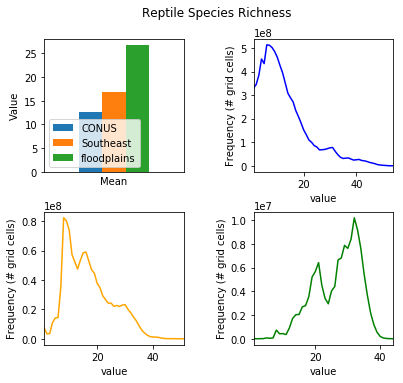

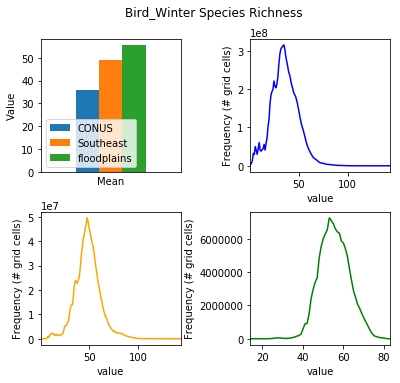

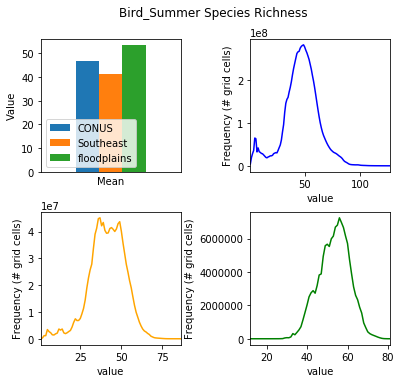

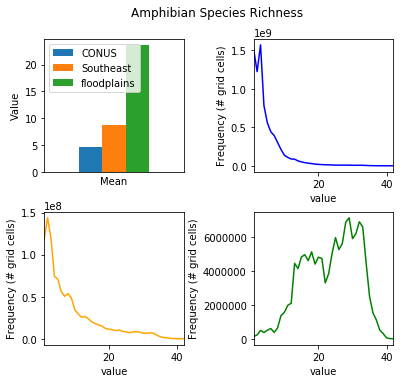

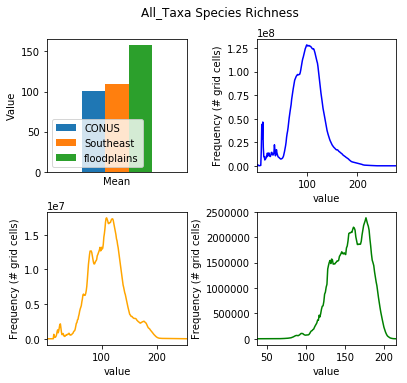

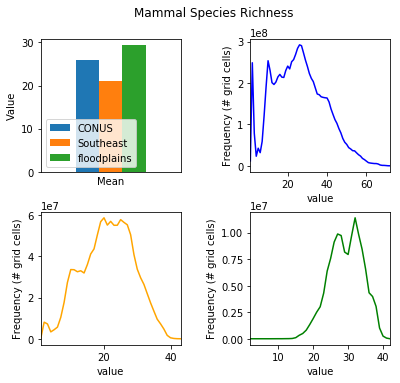

In [17]:
fontSize=9

for group in richnessPathsCONUS.keys():
    mainFig = plt.figure(figsize=(4,4), frameon=True)
    mainFig.suptitle(group.title() + " Species Richness")
    
    conusStats = ga.misc.RATStats(richnessPathsCONUS[group],
                                  percentile_list=[25, 50, 75],
                                  dropMax=True, dropZero=True)
    conusStats["name"] = "CONUS"
    seStats = ga.misc.RATStats(richnessPathsSE[group],
                                  percentile_list=[25, 50, 75],
                                  dropMax=True, dropZero=True)
    seStats["name"] = "Southeast"
    floodStats = ga.misc.RATStats(richnessPathsFlood[group],
                                  percentile_list=[25, 50, 75],
                                  dropZero=True)
    floodStats["name"] = "floodplains"
    
    # CONUS
    conusRAT = ga.misc.RATtoDataFrame(richnessPathsCONUS[group])
    conusRAT = conusRAT[:-1]
    conusRAT = conusRAT[conusRAT.index > 0]
    ax1 = mainFig.add_subplot(2,2,2)
    conusRAT.plot(ax=ax1, kind="line", legend=False, title="", color="blue")
    ax1.set_ylabel("Frequency (# grid cells)")
    
    # SE
    seRAT = ga.misc.RATtoDataFrame(richnessPathsSE[group])
    seRAT = seRAT[seRAT.index > 0]
    ax3 = mainFig.add_subplot(2,2,3)
    seRAT.plot(ax=ax3, kind="line", legend=False, title="", color="orange")
    ax3.set_ylabel("Frequency (# grid cells)")
    
    # Floodplains
    floodRAT = ga.misc.RATtoDataFrame(richnessPathsFlood[group])
    floodRAT = floodRAT[floodRAT.index > 0]
    ax2 = mainFig.add_subplot(2,2,4)
    floodRAT.plot(ax=ax2, kind="line", legend=False, title="", color="green")
    ax2.set_ylabel("Frequency (# grid cells)")
    
    # Figure with comparison of means
    meansDF = pd.DataFrame(index=["mean"], columns=["CONUS", "Southeast", 
                                                    "floodplains"])
    meansDF.loc["mean", "CONUS"] = conusStats["mean"]
    meansDF.loc["mean", "Southeast"] = seStats["mean"]
    meansDF.loc["mean", "floodplains"] = floodStats["mean"]
    ax4 = mainFig.add_subplot(2,2,1)
    meansDF.plot(ax=ax4, kind="bar", figsize=(5,5))
    ax4.set_ylabel("Value")
    ax4.set_xlabel("Mean")
    ax4.axes.get_xaxis().set_ticks([])
    if group == "amphibian":
        plt.legend(loc=2)
    else:
        plt.legend(loc=3)
    
    plt.subplots_adjust(left=0.02, bottom=.04, right=.99, top=.89, 
                        wspace=.5, hspace=.3)
    
    #mainFig.savefig(resultDir + "{0} mean chart.png".format(group),
                    #bbox_inches="tight", dpi=600)

# How much of each species' habitat is woody wetlands?
These processes are slow (1 hr per species), so I broke them up into four lists
to run simultaneously on different kernels.  The code here is what it would look like to run all on one kernel, which could take over a month.

In [ ]:
######################################### Calculate representation on floodplains forests
#########################################################################################
scratchDir = tempDir
maps = null123List
dfSpFF1 = ga.habitat.PercentOverlay(zoneFile=floodplainBinary,
                                   zoneName="Floodplain",
                                   zoneField="VALUE",
                                   habmapList=maps,
                                   habDir=habMapDir,
                                   workDir=resultDir+"Percent_FloodplainForest",
                                   snap=snap_raster,
                                   scratchDir=scratchDir,
                                   extent="zoneFile")

# Summarize amounts of species' habitat in woody wetlands
This code summarizes the results of the above cell and generates a descriptive table, lists 
of summer and winter species with dependence on the system, and graphs of frequency distribution 
of amount that species' habitat occurs in floodplain forests.

381 species use the systems of interest

38 species with more than 50.0% of winter habitat in floodplain forests:
	Mud Salamander
	Two-toed Amphiuma
	Barking Treefrog
	Chamberlain's Dwarf Salamander
	Dwarf Salamander
	Greater Siren
	Lesser Siren
	Neuse River Waterdog
	Ornate Chorus Frog
	Southern Cricket Frog
	Southern Dusky Salamander
	Three-lined Salamander
	Plain-bellied Watersnake
	Pond Slider
	Rainbow Snake
	Red-bellied Mudsnake
	Southern Watersnake
	Cottonmouth
	Prothonotary Warbler
	Atlantic Coast Slimy Salamander
	Brimley's Chorus Frog
	Carpenter Frog
	Dwarf Waterdog
	Mabee's Salamander
	Many-lined Salamander
	Southern Chorus Frog
	Anhinga
	American Alligator
	Brown Watersnake
	Eastern Mud Turtle
	Glossy Crayfish Snake
	Striped Mud Turtle
	Loggerhead Musk Turtle
	One-toed Amphiuma
	Delmarva Fox Squirrel
	Southeastern Slimy Salamander
	Alabama Red-bellied Cooter
	Gulf Coast Waterdog

40 species with more than 50.0% of summer habitat in floodplain forests:
	Mud Salamander
	Two-to

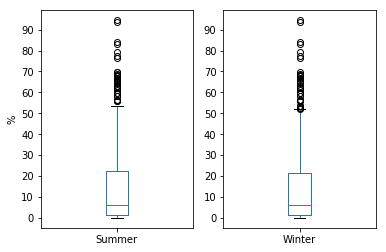

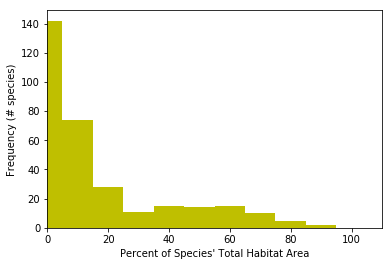

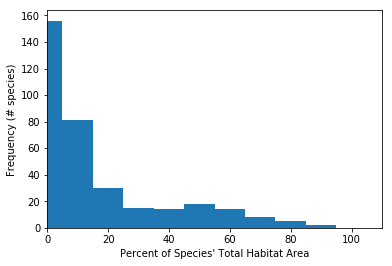

In [35]:
########################################################## Read in master table
###############################################################################
df0 = pd.read_csv(overlayTable)

###################################################### Add species name columns
###############################################################################
df0["common_name"] = [gp.gapdb.NameCommon(s) for s in df0.strUC]
df0["scientific_name"] = [gp.gapdb.NameSci(s) for s in df0.strUC]

############################################################# Descriptive stats
###############################################################################
# Remove placeholder rows and species with no ovelap in any season
df1 = df0[df0.Zone != placeholder_code]
df1 = df1[(df1.PercSummer != 0) | (df1.PercWinter != 0)]
df2 = df1.drop(["Zone", "NonHabitatPixels", "SummerPixels", "WinterPixels", 
             "AllYearPixels", "ZoneTotal", "SummerPixelTotal", "WinterPixelTotal",
             "AllYearPixelTotal", "Date", "RunTime", "GeoTiff", "strUC", 
             "PercYearRound"], axis=1)
print("{0} species use the systems of interest".format(len(df2)))
df2.to_csv(resultDir + "Species that use floodplain systems.csv")

# Summer and winter need to be described separately so that zeros can be
# properly ommitted.
descSum0 = df2.drop(["PercWinter", "common_name", "scientific_name"],
                   axis=1)
descSum = descSum0[descSum0.PercSummer > 0].describe(percentiles=np.arange(0, 1, .01))
#descSum.to_csv(resultDir + "Overlay descriptive statistics SUMMER.csv")
descWint0 = df2.drop(["PercSummer", "common_name", "scientific_name"],
                   axis=1)
descWint = descWint0[descWint0.PercWinter > 0].describe(percentiles=np.arange(0, 1, .01))
#descWint.to_csv(resultDir + "Overlay descriptive statistics WINTER.csv")


################################################ Box plots of summer and winter
###############################################################################
# Manipulate tables
df1summer = df1.filter(["strUC", "PercSummer"], axis=1).set_index(["strUC"])
df1winter = df1.filter(["strUC", "PercWinter"], axis=1).set_index(["strUC"])
df1summer.rename(columns={"PercSummer":"Summer"}, inplace=True)
df1winter.rename(columns={"PercWinter":"Winter"}, inplace=True)
df1summer = df1summer[df1summer.Summer > 0]
df1winter = df1winter[df1winter.Winter > 0]

# Graph
fig = plt.figure()
ax2 = fig.add_subplot(1,2,1)
df1summer.plot(ax = ax2, kind="box", yticks=range(0,100, 10))
ax2.set_ylabel("%")
ax3 = fig.add_subplot(1,2,2)
df1winter.plot(ax = ax3, kind="box", yticks=range(0,100, 10))
#fig.savefig(resultDir + "Overlay boxplot.png", dpi=600)


############################################## Filter out non dependent species
###############################################################################
# Assign cutoff for filtering    ############################              What value to use?
threshold = 50.0

# Filter out the records corresponding to 0/nodata/99.
dfSpFF = df0.loc[df0.Zone != placeholder_code]

# Filter dataframe for top species and save, also make list for below
winterSp = dfSpFF[dfSpFF["PercWinter"] >= threshold]
winterSp.to_csv(winterTopSpList)
print("\n{0} species with more than {1}% of winter habitat in floodplain forests:".format(len(winterSp.strUC), threshold))
for x in [gp.gapdb.NameCommon(x) for x in list(winterSp.strUC)]:
    print("\t" + x)

summerSp = dfSpFF[dfSpFF["PercSummer"] >= threshold]
#summerSp.to_csv(summerTopSpList)
print("\n{0} species with more than {1}% of summer habitat in floodplain forests:".format(len(summerSp.strUC), threshold))
for x in [gp.gapdb.NameCommon(x) for x in list(summerSp.strUC)]:
    print("\t" + x)

topSp = dfSpFF[(dfSpFF["PercSummer"] >= threshold) | (dfSpFF["PercWinter"] >= threshold)]
#topSp.to_csv(TopSpList)


######################################## Histogram of percSummer and percWinter
###############################################################################
# Summer
df1summer = df1.filter(["strUC", "PercSummer"], axis=1).set_index(["strUC"])
df1summer = df1summer[df1summer.PercSummer > 0]
bins = np.arange(0, 110, 10)-5    # this enables bins to sit above x ticks, note it's 1 + desired bin number
ax = df1summer.plot(kind="hist", legend=False, color=['y'], bins=bins, # note limit is 1 + desired bin number
                     xlim=(0,110))
ax.set_xlabel("Percent of Species' Total Habitat Area")
ax.set_ylabel("Frequency (# species)")
fig = plt.gcf()
#fig.savefig(resultDir + "Summer overlay histogram.png", dpi=600)

# Winter
df1winter = df1.filter(["strUC", "PercWinter"], axis=1).set_index(["strUC"])
df1winter = df1winter[df1winter.PercWinter > 0]
ax3 = df1winter.plot(kind="hist", legend=False, bins=bins, # note limit is 1 + desired bin number
                     xlim=(0,110))
ax3.set_xlabel("Percent of Species' Total Habitat Area")
ax3.set_ylabel("Frequency (# species)")
fig3 = plt.gcf()
#fig3.savefig(resultDir + "Winter overlay histogram.png", dpi=600)

# Map the species richness of "top" woody wetland species.
A "top" species is one with over 50% of it's habitat occuring in SE woody wetlands.


In [ ]:
##################################### Map richness of top species (winter and summer)
#####################################################################################
# Winter
winterDF = pd.read_csv(winterTopSpList)

winterSp = list(winterDF.strUC)
winterTiffs = [x + "_v1.tif" for x in winterSp]
wRichnessMap = ga.richness.MapRichness(spp=winterTiffs, groupName="Top_Winter",
                                       outLoc=resultDir,
                                       modelDir=seasonalhabMapDir,
                                       season="Winter",
                                       intervalSize=40,
                                       CONUSExtent=conus_extent)
# Summer
summerDF = pd.read_csv(summerTopSpList)
summerSp = list(summerDF.strUC)
summerTiffs = [x + "_v1.tif" for x in summerSp]
sRichnessMap = ga.richness.MapRichness(spp=summerTiffs, groupName="Top_Summer",
                                       outLoc=resultDir, 
                                       modelDir=seasonalhabMapDir,
                                       season="Summer", 
                                       intervalSize=40,
                                       CONUSExtent=conus_extent)


#########################################  Mask the richness with the floodplain layer
######################################################################################
maskedWinter = arcpy.sa.ExtractByMask(wRichnessMap, arcpy.Raster(floodplainBinary))
#maskedWinter.save(resultDir + "maskedRichnessWinter.tif")

maskedSummer = arcpy.sa.ExtractByMask(sRichnessMap, arcpy.Raster(floodplainBinary))
#maskedSummer.save(resultDir + "maskedRichnessSummer.tif")

# Assess protection
Produces results related to the protection of ecological systems
and species.  Note that some processes (lines 33-35) take up to an hour to run
and could be skipped if the floodPAD layer already exists. Also note that this
code queries the Analytic Databse.

###  How much of floodplain forest is protected?

In [ ]:
PAD = arcpy.Raster(PADUS_Status)
FloodBin = arcpy.Raster(resultDir + "Floodplain.tif")

# Overlay the PAD layer and binary floodplain layer
floodPAD = PAD * (FloodBin - 9)
#floodPAD.save(resultDir + "FloodplainPAD.tif")

# Make a pie chart of protection
floodPADRAT = ga.misc.RATtoDataFrame(resultDir + "FloodplainPAD.tif")
ax = floodPADRAT.plot(y="cell_count", kind='Pie', figsize=(4,4), autopct='%.2f',
                 legend=False,
                 colors = ["#009933", "#cccc00", "#999999", "#e6e6e6"])
ax.set_ylabel("%")
fig = plt.gcf()
#fig.savefig(resultDir + "Flooplain protection.png", dpi=600,
 #           bbox_inches="tight")

### How much of each floodplain system is protected?

In [19]:
def getEcoSysProtection(ecoSys):
    '''
    (string, list) -> pandas DataFrame
    
    Description:
    A function that returns the percentage of an ecological system
        that is in the GAP PAD statuses of interest.
    
    Argument:
    ecoSys -- The name of the ecological system that you are interested in.
    '''
    blank = pd.DataFrame(index = ["1","2","3","4", "1234"], 
                         columns=["cells", "percent"])
    try:
        # Connect to analytic database
        anCur, anCon = gp.gapdb.ConnectAnalyticDB()
        
        sql = """
        --Retrieve ecological system boundary info for one system.
        WITH ESPAD AS (
        SELECT lu_boundary_gap_landfire.boundary, lu_boundary_gap_landfire.count,
               lu_boundary_gap_landfire.gap_landfire, lu_boundary.value, lu_boundary.padus1_4, 
               padus1_4.revoid, padus1_4.gap_sts
        FROM lu_boundary_gap_landfire 
        INNER JOIN lu_boundary ON lu_boundary.value = lu_boundary_gap_landfire.boundary
        INNER JOIN padus1_4 ON lu_boundary.padus1_4 = padus1_4.revoid),
        
        --Retrieve ecological system name and code
        ECOSYS AS (
        SELECT g.ecosys_lu, g.value
        FROM gap_landfire as g
        WHERE g.ecosys_lu = '{0}')
        
        --Group records from joined data views by count
        SELECT ESPAD.gap_sts, sum(ESPAD.count) AS cells
        FROM ECOSYS INNER JOIN ESPAD ON ECOSYS.value = ESPAD.gap_landfire
        GROUP BY ESPAD.gap_sts
        """.format(ecoSys)
        
        qryDF = pd.read_sql(sql, anCon).set_index("gap_sts")
        qryDF.loc["1234", "cells"] = sum(qryDF.cells)
        qryDF["percent"] = [100*(qryDF.loc[i, "cells"]/qryDF.loc["1234", "cells"]) for i in qryDF.index]
        
        del anCur
        anCon.close()
        
        for x in qryDF.index:
            blank.loc[x, "cells"] = qryDF.loc[x, "cells"]
            blank.loc[x, "percent"] = qryDF.loc[x, "percent"]
            blank.fillna(0, inplace=True)
        return blank
    except Exception as e:
        print(e)

floodSysDF = pd.read_csv(floodplainSystemCSV)
floodSysDF = floodSysDF[floodSysDF.include == 1]
floodSysDF.drop(["notes", "include"], inplace=True, axis=1)
floodSysDF["protected1&2(%)"] = [sum(getEcoSysProtection(i).iloc[:2].percent) for i in floodSysDF.system_name]
print(floodSysDF)
#floodSysDF.to_csv(resultDir + "EcolSysProtection.csv")

    map_code                                        system_name  protected1&2(%)
10      9801  Atlantic Coastal Plain Blackwater Stream Flood...         2.372654
11      9845  Atlantic Coastal Plain Brownwater Stream Flood...        15.747875
12      9301  Atlantic Coastal Plain Nonriverine Swamp and W...        12.159917
13      9302  Atlantic Coastal Plain Nonriverine Swamp and W...        13.354839
14      9235  Atlantic Coastal Plain Northern Tidal Wooded S...        24.546079
15      9843  Atlantic Coastal Plain Small Blackwater River ...         9.054003
16      9842  Atlantic Coastal Plain Small Brownwater River ...        22.954305
17      9218  Atlantic Coastal Plain Southern Tidal Wooded S...        19.374362
18      9804  East Gulf Coastal Plain Large River Floodplain...        16.079641
19      9851  East Gulf Coastal Plain Small Stream and River...         4.350791
20      9210         East Gulf Coastal Plain Tidal Wooded Swamp        31.721071
21      9213      Gulf and A

###  Summarize protection of species' habitat


*** SUMMER ***
           status_1      status_2      status_3      status_4   total_cells  status_1%  status_2%  status_3%  status_4%
count  4.000000e+01  4.000000e+01  4.000000e+01  4.000000e+01  4.000000e+01  40.000000  40.000000  40.000000  40.000000
mean   2.675273e+06  6.426929e+06  8.377446e+06  6.716559e+07  8.464524e+07   2.513164   6.994777   9.377807  81.114252
std    2.628849e+06  5.506099e+06  7.044157e+06  5.216043e+07  6.610806e+07   1.768193   2.396684   3.986807   5.898839
min    0.000000e+00  4.970000e+03  3.240000e+04  1.708640e+05  2.206920e+05   0.000000   0.664846   2.966778  68.249953
25%    2.718388e+05  1.030034e+06  1.808467e+06  2.070537e+07  2.300780e+07   1.095587   5.833598   6.521259  77.329739
50%    2.489427e+06  6.062492e+06  8.539485e+06  5.799312e+07  7.791564e+07   2.404323   7.302339   9.224928  80.243073
75%    3.884678e+06  1.012281e+07  1.138476e+07  9.842002e+07  1.237062e+08   3.516467   8.090132  11.515021  84.446728
max    1.006490e+07  1.8

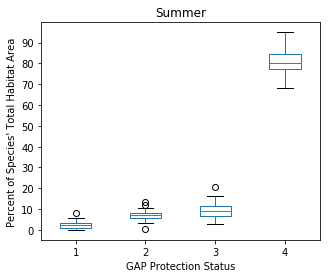

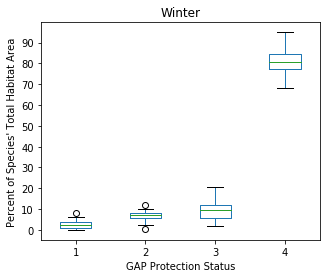

In [21]:
# Function to return protection status of a species.
def getProtection(strUC, season):
    '''
    (string, string) -> pandas DataFrame
    
    Description:
    A function that returns the amount of a species' habitat that is in status
    1, 2, 3, and 4 lands by season.
    
    Arguments:
    strUC -- Species code (e.g., "mVASHx")
    season -- Season to summarize on (i.e., summer, winter, or all year)
    '''
    try:
        seasonDict = {"summer":(1,3), "winter":(2,3), "all year":(3,3)}
        
        # Connect to analytic database
        anCur, anCon = gp.gapdb.ConnectAnalyticDB()
        
        sql = """
        --Retrieve species boundary info for one species.
        WITH SpPAD AS (
        SELECT lu_boundary_species.boundary, lu_boundary_species.count, 
               lu_boundary_species.season, lu_boundary_species.species_cd, 
               lu_boundary.value, lu_boundary.padus1_4, padus1_4.revoid, 
               padus1_4.gap_sts
        FROM lu_boundary_species 
        INNER JOIN lu_boundary ON lu_boundary.value = lu_boundary_species.boundary
        INNER JOIN padus1_4 ON lu_boundary.padus1_4 = padus1_4.revoid
        WHERE (lu_boundary_species.species_cd = '{0}' 
               and (lu_boundary_species.season = {1} or lu_boundary_species.season = {2})))
        
        
        --Group by count
        SELECT  s.gap_sts, sum(s.count) AS cells
        FROM SpPAD AS s
        GROUP BY s.gap_sts
        """.format(strUC, str(seasonDict[season][0]), str(seasonDict[season][1]))
        
        qryDF = pd.read_sql(sql, anCon).set_index("gap_sts")
        
        del anCur
        anCon.close()
        
        return qryDF
    except Exception as e:
        print(e)

# Get list of species to query.
summerDF = pd.read_csv(summerTopSpList)
summerSp = list(summerDF.strUC)
winterDF = pd.read_csv(winterTopSpList)
winterSp = list(winterDF.strUC)

# Empty dataframes to fill out.
summer0 = pd.DataFrame(index=summerSp, 
                       columns=["status_1", "status_2", "status_3", "status_4"])
winter0 = pd.DataFrame(index=winterSp, 
                       columns=["status_1", "status_2", "status_3", "status_4"])

#### Fill out summer DF
print("\n*** SUMMER ***")
for sp in summerSp:
    prot = getProtection(sp, season="summer")
    try:
        summer0.loc[sp, 'status_1'] = int(prot.loc["1"])
    except: 
        summer0.loc[sp, 'status_1'] = 0
    try:
        summer0.loc[sp, 'status_2'] = int(prot.loc["2"])
    except:
        summer0.loc[sp, 'status_2'] = 0
    try:
        summer0.loc[sp, 'status_3'] = int(prot.loc["3"])
    except:
        summer0.loc[sp, 'status_3'] = 0
    try:
        summer0.loc[sp, 'status_4'] = int(prot.loc["4"])
    except:
        summer0.loc[sp, 'status_4'] = 0
summer0["total_cells"] = summer0.status_1 + summer0.status_2 + summer0.status_3 + summer0.status_4
summer0['status_1%'] = 100.*summer0.status_1/summer0.total_cells
summer0['status_2%'] = 100.*summer0.status_2/summer0.total_cells
summer0['status_3%'] = 100.*summer0.status_3/summer0.total_cells
summer0['status_4%'] = 100.*summer0.status_4/summer0.total_cells

# Summer protection description
summer1 = summer0.apply(pd.to_numeric)
summer1.to_csv(resultDir + "Summer protection.csv")
summerProtDesc = summer1.describe()
print(summerProtDesc)
#summerProtDesc.to_csv(resultDir + "Summer protection descriptive stats.csv")
    
# Graph protection
dropCols = ["status_1", "status_2", "status_3", "status_4", "total_cells"]
# Summer
summer2 = summer1.drop(dropCols, axis=1)
summer2.rename(columns={"status_1%":"1", "status_2%":"2","status_3%":"3",
                        "status_4%":"4",}, inplace=True)
sumAx = summer2.plot(kind="box", title="Summer", yticks=range(0,100,10),
                     figsize=(5,4))
sumAx.set_ylabel("Percent of Species' Total Habitat Area")
sumAx.set_xlabel("GAP Protection Status")
fig = plt.gcf()
#fig.savefig(resultDir + "Protection Boxplot Summer.png", dpi=600,
            #bbox_inches="tight")

#### Fill out winter DF
print("\n*** WINTER ***")
for sp in winterSp:
    prot = getProtection(sp, season="winter")
    try:
        winter0.loc[sp, 'status_1'] = int(prot.loc["1"])
    except: 
        winter0.loc[sp, 'status_1'] = 0
    try:
        winter0.loc[sp, 'status_2'] = int(prot.loc["2"])
    except:
        winter0.loc[sp, 'status_2'] = 0
    try:
        winter0.loc[sp, 'status_3'] = int(prot.loc["3"])
    except:
        winter0.loc[sp, 'status_3'] = 0
    try:
        winter0.loc[sp, 'status_4'] = int(prot.loc["4"])
    except:
        winter0.loc[sp, 'status_4'] = 0
        
winter0["total_cells"] = winter0.status_1 + winter0.status_2 + winter0.status_3 + winter0.status_4
winter0['status_1%'] = 100.*winter0.status_1/winter0.total_cells
winter0['status_2%'] = 100.*winter0.status_2/winter0.total_cells
winter0['status_3%'] = 100.*winter0.status_3/winter0.total_cells
winter0['status_4%'] = 100.*winter0.status_4/winter0.total_cells

# Winter protection description
winter1 = winter0.apply(pd.to_numeric)
#winter1.to_csv(resultDir + "Winter protection.csv")
winterProtDesc = winter1.describe()
print(winterProtDesc)
#winterProtDesc.to_csv(resultDir + "Winter protection descriptive stats.csv")

# Winter
winter2 = winter1.drop(dropCols, axis=1)
winter2.rename(columns={"status_1%":"1", "status_2%":"2","status_3%":"3",
                        "status_4%":"4",}, inplace=True)
wintAx = winter2.plot(kind="box", title="Winter", yticks=range(0,100,10),
                      figsize=(5,4))
wintAx.set_ylabel("Percent of Species' Total Habitat Area")
wintAx.set_xlabel("GAP Protection Status")
fig = plt.gcf()
#fig.savefig(resultDir + "Protection Boxplot Winter.png", dpi=600,
            #bbox_inches="tight")

###  Make table of status 1 or 2 protection for top species

In [23]:
# get combined species list
tops = set(summerSp) | set(winterSp)

# Define function to find out how much habitat is in status 1 or 2
def status1or2(strUC, season):
    '''
    (string, string) -> float
    
    Description:
        Determines what percentage of species's seasonal habitat is in status
    1 or 2.
    '''
    # Blank DataFrame to fill out
    blank = pd.DataFrame(index = ["1","2","3","4"], 
                         columns=["cells", "percent"])
    # Get the protection amounts from Analytic DB
    one = getProtection(strUC, season)
    # Fill out the blank table, use this blank so that errors don't occur
    # if a species' habitat is all in less than 4 statuses.
    for x in one.index:
            blank.loc[x, "cells"] = one.loc[x, "cells"]
            blank.fillna(0, inplace=True)
    # get total count and calculate the percentage in 1 or 2 status.
    total = float(blank.cells.sum())
    protDF = blank.iloc[:2]
    protCells = protDF.cells.sum()
    return 100*(protCells/total)
  
# Fill out a DataFrame
df10 = pd.DataFrame(index=tops, columns=["summer", "winter"])
df10["common_name"] = [gp.gapdb.NameCommon(s) for s in df10.index]
df10["summer"] = [status1or2(strUC, "summer") for strUC in df10.index]
df10["winter"] = [status1or2(strUC, "winter") for strUC in df10.index]
#df10.fillna(0, inplace=True).sort()
print(df10)
#df10.to_csv(resultDir + "TopSpeciesProtection1or2.csv")

           summer     winter                      common_name
rGCRSx  10.025292  10.025292            Glossy Crayfish Snake
aDWWAx   9.842980   9.842980                   Dwarf Waterdog
aCHDSx   5.359766   5.359766   Chamberlain's Dwarf Salamander
aCRFRx  15.743023  15.743023                   Carpenter Frog
aNRWAx   0.675147   0.675147             Neuse River Waterdog
bANHIx  13.293663  14.860495                          Anhinga
bLOWAx  16.193208        NaN            Louisiana Waterthrush
aMBSAx  13.210186  13.210186               Mabee's Salamander
rPBWAx   8.472648   8.472648         Plain-bellied Watersnake
aOTAMx   7.362516   7.362516                One-toed Amphiuma
rSOWAx  12.618540  12.618540              Southern Watersnake
rCOTTx  11.651370  11.651370                      Cottonmouth
rLMTUx   4.315399   4.315399           Loggerhead Musk Turtle
rARBCx   7.686731   7.686731       Alabama Red-bellied Cooter
rPOSLx   9.877628   9.877628                      Pond Slider
mNOMYx  